# Clustering the papers using Topic Models 
## Latent Dirichlet Allocation (LDA) using Gensim and Scikit-Learn Implementations; Non-Negative Matrix Factorization using Scikit-Learn implementation

The idea is to first cluster the papers based on latent topics and then use the relevant topic for each task.

High level overview of steps:
* Read files
* Extract abstracts
* Pre-process
* Create Bag of Words/TF-IDF
* LDA using Gensim, Sklearn, NMF using Sklearn
* Visualize using pyLDAvis, update number of topics


### 1. **Load packages and set preliminaries**

In [ ]:
# load packages
import numpy as np 
import pandas as pd
import os
import json
import gensim
import nltk
import unidecode
import string
import pyLDAvis.gensim, pyLDAvis.sklearn
import pickle

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim import corpora, models
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import stopwords

np.random.seed(2020)

In [ ]:
# files/folders available
path = '/kaggle/input/CORD-19-research-challenge/'
os.listdir(path)

### 2. **Read files from commercial use subfolder**

In [ ]:
os.chdir(os.path.join(path,'comm_use_subset/comm_use_subset/pdf_json'))
file_list = os.listdir(os.getcwd())
## Read files from the folder and store in a df
article_df = pd.DataFrame()
for file in file_list:
    article_data = pd.read_json(file, orient = 'index')
    article_df = article_df.append(article_data.T, ignore_index = True)

### 3. **Extract abstracts from the dataset and pre-process**

In [ ]:
## Extract titles/abstracts
titles = [x['title'] for x in article_df.metadata]
abstracts = [x[0]['text'] for x in article_df.abstract if x!=[]] 
len(abstracts)

**Pre-processing the abstracts**

Pre-processing using following steps:

* Convert to lower case
* Remove accented characters
* Remove punctuation
* Remove stop words
* Remove some extra words that are quite common -- virus, study, human, infection
* Lemmatization

In [ ]:
stop_words = set(stopwords.words('english'))

def text_preprocess(text):
    lemma = nltk.wordnet.WordNetLemmatizer()
    #Convert to lower
    text = text.lower()
    #Remove accented characters
    text = unidecode.unidecode(text)
    #Remove punctuation
    table = str.maketrans('', '', string.punctuation)
    text = [w.translate(table) for w in text.split()]
    lemmatized = []
    #Lemmatize non-stop words and save
    other_words = ['virus','study','viral','human','infection']
    for word in text:
        if word not in stop_words:
            x = lemma.lemmatize(word)
            if x not in other_words:
                lemmatized.append(x)
    return lemmatized

In [ ]:
%%time
#Preprocess each abstract and store in a list
preprocessed_docs = []
for abstract in abstracts:
    pre_processed_abstract = text_preprocess(abstract)
    preprocessed_docs.append(pre_processed_abstract)

**Create dictionary, bag of words corpus and tf-idf mx**

In [ ]:
%%time
#Create dictionary from set of abstracts
dictionary = gensim.corpora.Dictionary(preprocessed_docs)

#Filter extremes - remove all words that occur less than 15 times and more than 50% of document; only keep 100,000 of the remaining
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

# Create Bag of Words and TF-IDF (LDA on TF-IDF is not recommended but some practitioners still do it) 
bow_corpus = [dictionary.doc2bow(doc) for doc in preprocessed_docs]
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

### 4. Run the models

**4.1 LDA model - BoW**

In [ ]:
%%time
###Takes around 12 minutes for 100 passes
#Create the Gensum LDA model on BoW;
lda_model_bow = gensim.models.LdaMulticore(bow_corpus, num_topics=3, id2word=dictionary, passes=50, workers=2)
for idx, topic in lda_model_bow.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

In [ ]:
%%time
## Using PyLDAVis to visualize the topic model
## The lambda value for the viz should be set between 0.2 and 0.4 according to 
# When lambda = 1, the relevance score = P(word | topic k), in other words their frequency count.
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model_bow, bow_corpus, dictionary)

**4.2 LDA model - TFIDF**

In [ ]:
%%time
###Takes around 20 minutes for 100 passes
# Create LDA topic-model; 3 topics for now based on trial and error
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=3, id2word=dictionary, passes=50, workers=4, random_state = 0)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

In [ ]:
%%time
## Using PyLDAVis to visualize the topic model
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model_tfidf, corpus_tfidf, dictionary)

In [ ]:
### Add the estimated topic/cluster for each abstract in the df (subset to remove empty abstracts)

topic_list = []
score_list = []

for doc in corpus_tfidf:
    topic,score = max(lda_model_tfidf[doc], key=lambda x: x[1]) #find max value of the topic probabilities for doc
    topic_list.append(topic)
    score_list.append(score)
    
topic_list_bow = []
score_list_bow = []

for doc in bow_corpus:
    topic,score = max(lda_model_bow[doc], key=lambda x: x[1])
    topic_list_bow.append(topic)
    score_list_bow.append(score)

#Subset df to remove empty abstracts
article_df_subset = article_df[article_df.abstract.str.len() != 0]

article_df_subset.loc[:,'lda_tfidf_topic_number'] = topic_list
article_df_subset.loc[:,'lda_tfidf_topic_score'] = score_list
article_df_subset.loc[:,'lda_bow_topic_number'] = topic_list_bow
article_df_subset.loc[:,'lda_bow_topic_score'] = score_list_bow

**4.3 NMF**

In [ ]:
%%time

## Non-Negative Matrix Factorization (NMF) topic model using sklearn
no_features = 1000
docs = [' '.join(x) for x in preprocessed_docs]
# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(docs)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
no_topics = 4

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

In [ ]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(nmf, tfidf_feature_names, 20)

**4.4 LDA - Sklearn**

In [ ]:
%%time
#LDA using Scikit-Learn
no_features = 1000

docs = [' '.join(x) for x in preprocessed_docs]
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')

tfidf = tfidf_vectorizer.fit_transform(docs)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

#Set number of topics
no_topics = 3

# Run LDA
lda = LatentDirichletAllocation(n_components=3, max_iter=100, learning_method='online', learning_offset=50.,random_state=0).fit(tfidf)

Scikit-Learn LDA is much much quicker than gensim-LDA and gives similar results. Going ahead with the Scikit-Learn model.

In [ ]:
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda, tfidf, tfidf_vectorizer)

An overview of topics observed : 

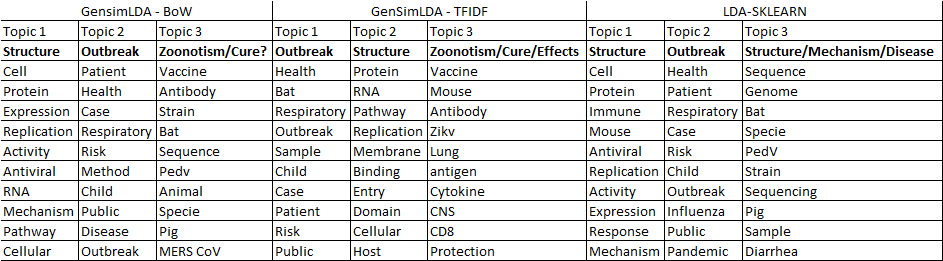

This is my interpretation of the topics based on the word relevance; it is up for discussion.
On subsequent runs, the top words may change but the overall topics seem to remain the same.

In [ ]:
#Extracting topic for each document, using sk-learn LDA
topic_sk_lda = []
for i in range(0,tfidf.shape[0]):
    topic_sk_lda.append(np.argmax(lda.transform(tfidf[i])))
    
## Add to subset DF
article_df_subset['topic_sk_lda'] = topic_sk_lda

In [ ]:
article_df_subset['topic_sk_lda'].value_counts()

In [ ]:
article_df_subset['lda_tfidf_topic_number'].value_counts()

In [ ]:
article_df_subset['lda_bow_topic_number'].value_counts()

### 5. Save models and DF

In [ ]:
path = '/kaggle/working/'
os.chdir(path)
Pkl_Filename = "Pickle_LDA_tfidf.pkl"  
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(lda_model_tfidf, file)    
    
Pkl_Filename = "Pickle_BOW_tfidf.pkl"  
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(lda_model_bow, file)
    
Pkl_Filename = "Pickle_LDA_sklearn_.pkl"  
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(lda, file)
    
article_df_subset.to_csv('article_df.csv')